In [1]:
!nvidia-smi

In [3]:
!pip freeze | grep keras
!pip freeze | grep Keras
!pip freeze | grep tensorflow
!pip freeze | grep h5py
!pip freeze | grep opencv 
!pip freeze | grep pandas

keras==2.7.0
keras-segmentation==0.3.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
tensorflow==2.7.0
tensorflow-estimator==2.7.0
tensorflow-io-gcs-filesystem==0.21.0
h5py==2.10.0
opencv-python==4.5.5.62
pandas==1.3.5


In [4]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1
# !pip install git+https://github.com/qubvel/segmentation_models

# for str decode error ... run it and restart runtime
# !pip uninstall h5py -y
!pip install h5py==2.10.0

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
# !tensorboard --logdir logs --host 0.0.0.0
# !pip install -U tensorboard-plugin-profile

In [6]:
i = !ls Dataset/IDD/images/
l = !ls Dataset/IDD/masks/
len(i), len(l)

(5966, 5966)

In [7]:
l[-5:], i[-5:]

(['frame9980.png',
  'frame9982.png',
  'frame9991.png',
  'frame9994.png',
  'frame99992.png'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

In [8]:
import cv2
from glob import glob
import os
import numpy as np

# 100 = background
# 101 = road
# 102 = obstacle(person, rider, car, truck, bus, train, motorcycle, bicycle)


l = glob('Dataset/IDD/masks/*')
m = cv2.imread(l[2970],0)
m.shape
np.unique(m)


array([0, 1, 2], dtype=uint8)

In [9]:
import os
len(os.listdir('Dataset/IDD/Test/images/')), len(os.listdir('Dataset/IDD/masks/'))

(1016, 5966)

In [10]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x, train_y, test_y = train_test_split(images,masks, test_size=0.1702, 
                                                        random_state=168, shuffle=True)
    return train_x, train_y, test_x, test_y

train_x, train_y, val_x, val_y = load_dataset('Dataset/IDD')
print(len(train_x), len(train_y), len(val_x), len(val_y))

4950 4950 1016 1016


### TF data API

In [11]:
train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(val_x, val_y))

In [12]:
IMG_SIZE = 512
def parse_x_y(img_path,mask_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask = tf.io.read_file(mask_path)    
    mask = tf.image.decode_png(mask, channels=1)  
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE),method='nearest')    
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    input_mask = tf.one_hot(input_mask, 3)
    input_mask = tf.reshape(input_mask, (IMG_SIZE, IMG_SIZE, 3))
    return input_image, input_mask

AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
BATCH_SIZE = 8
BUFFER_SIZE = 2*BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(parse_x_y)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_dataset =val_dataset.map(parse_x_y)

dataset = {"train": train_dataset, "val": val_dataset}

dataset['train'] = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(
    load_image_train, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [13]:
for image,label in dataset['train'].take(1):
    print("Train image: ",image.shape)
    print("Train label: ",label.shape,"\n\tunique values", np.unique(label[0]))
    
for image,label in dataset['val'].take(1):
    print("Val image: ",image.shape)
    print("Val label: ",label.shape,"\n\tunique values", np.unique(label[0]))

Train image:  (8, 512, 512, 3)
Train label:  (8, 512, 512, 3) 
	unique values [0. 1.]
Val image:  (8, 512, 512, 3)
Val label:  (8, 512, 512, 3) 
	unique values [0. 1.]


In [14]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(7, 7))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


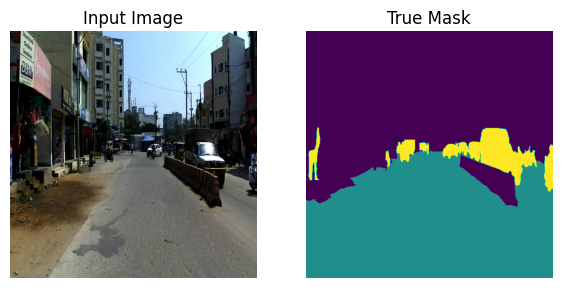

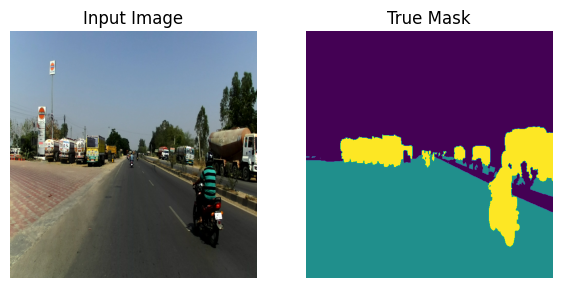

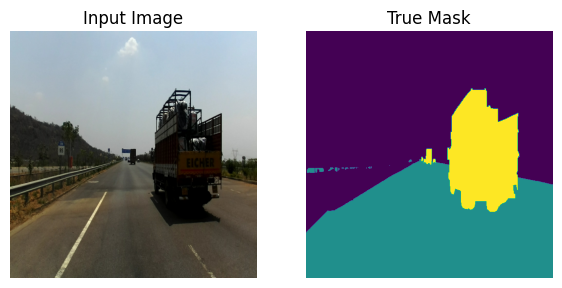

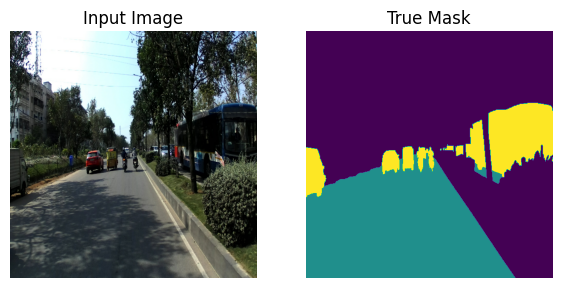

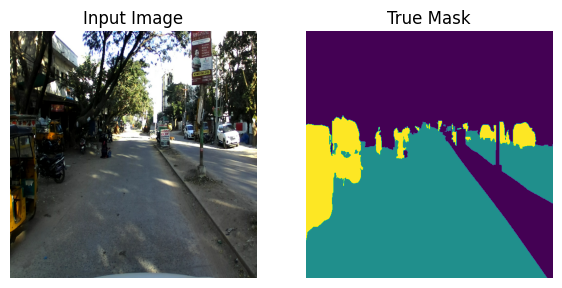

In [15]:
i=0
for image, mask in dataset['train'].take(5):
    i=i+1
#     print(i)
    sample_image, sample_mask = image, mask
    t = np.argmax(sample_mask[0],axis=-1)
    t = tf.expand_dims(t,axis=-1)
    display_sample([sample_image[0],t])

In [17]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [18]:
# !pip install keras-segmentation

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.SeparableConv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [28]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
def DeeplabV3Plus(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3),name="input_image")
    encoder = MobileNetV2(
        input_tensor=inputs,
        weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5",
        include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_3_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output    
    x = DilatedSpatialPyramidPooling(encoder_output)
    t = encoder.get_layer("input_image").output

    f = [16, 32]
    for i in range(1, len(skip_connection_names)+1, 1):                
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((4, 4),interpolation="bilinear")(x)
        print(x.shape)
        x = Concatenate()([x, x_skip])        
        x = SeparableConv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = SeparableConv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)        
    
    x = Conv2D(num_classes, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    
    return model


model = DeeplabV3Plus(image_size=IMG_SIZE, num_classes=3)
model.summary()

(None, 128, 128, 256)
(None, 512, 512, 32)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 16  64          ['Conv1[0][0]']                  
                                )                

                                )                                 'tf.nn.relu_43[0][0]',          
                                                                  'tf.nn.relu_44[0][0]',          
                                                                  'tf.nn.relu_45[0][0]',          
                                                                  'tf.nn.relu_46[0][0]']          
                                                                                                  
 separable_conv2d_59 (Separable  (None, 32, 32, 256)  328960     ['concatenate_15[0][0]']         
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 32, 32, 256)  1024       ['separable_conv2d_59[0][0]']    
 ormalization)                                                                                    
          

In [22]:
# from tensorflow.keras.applications import MobileNetV2
# encoder = MobileNetV2(input_shape=[512,512,3], weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5", include_top=False, alpha=0.35)
# # encoder.load_weights("pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5")

In [23]:
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

# from tensorflow.keras.models import load_model
# model = load_model('IDD_mobilenetV2_edge/ckpt_path/350.h5',
#                    custom_objects={'dice_loss_plus_categorical_crossentropy_plus_jaccard_loss':ls,
#                                    'precision':precision, 'recall':recall, 'f1-score':f1_score, 'iou_score':iou_score})

Segmentation Models: using `tf.keras` framework.


In [24]:
import os, time, keras
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Hyperparamaters """
BATCH_SIZE = 8
epochs = 1000
base_dir = 'RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(f"{base_dir}/ckpt_path")
    
csv_path = f"{base_dir}/history.csv"

""" callbacks """
root_logdir = os.path.join(os.curdir, f"{base_dir}/logs","fit","")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1,profile_batch='10,15')

checkpoint_filepath = f'{base_dir}/'+'ckpt_path/{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 1,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
#     EarlyStopping(monitor="val_loss", patience=10),
    tensorboard_cb
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

test_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    test_steps += 1

print("train_steps", train_steps, "test_steps",test_steps)

# """ Model training """
# for layer in model.layers:
#     if layer.name == "global_average_pooling2d":
#         break
#     else:
#         layer.trainable = False

# for layer in model.layers:
#     print(layer.name,layer.trainable)

model.compile(
    loss=ls,
    optimizer= "adam", #tf.keras.optimizers.Adam(lr),
    metrics=metrics
)
# model.summary()

env: SM_FRAMEWORK=tf.keras
train_steps 619 test_steps 127


In [25]:
# pretrain model decoder
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1000
619/619 [==============================] - ETA: 0s - loss: 0.3995 - precision: 0.8697 - recall: 0.8883 - f1-score: 0.8740 - iou_score: 0.7938
Epoch 00001: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/1.h5
619/619 [==============================] - 400s 630ms/step - loss: 0.3995 - precision: 0.8697 - recall: 0.8883 - f1-score: 0.8740 - iou_score: 0.7938 - val_loss: 1.1097 - val_precision: 0.7183 - val_recall: 0.7577 - val_f1-score: 0.6660 - val_iou_score: 0.5322 - lr: 0.0010
Epoch 2/1000
619/619 [==============================] - ETA: 0s - loss: 0.2360 - precision: 0.9318 - recall: 0.9345 - f1-score: 0.9321 - iou_score: 0.8779
Epoch 00002: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/2.h5
619/619 [==============================] - 390s 630ms/step - loss: 0.2360 - precision: 0.9318 - recall: 0.9345 - f1-score: 0.9321 - iou_score: 0.8779 - val_loss: 2.2912 - val_precision: 0.6769 - val_recal

619/619 [==============================] - ETA: 0s - loss: 0.1185 - precision: 0.9676 - recall: 0.9670 - f1-score: 0.9673 - iou_score: 0.9377
Epoch 00031: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/31.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
619/619 [==============================] - 383s 618ms/step - loss: 0.1185 - precision: 0.9676 - recall: 0.9670 - f1-score: 0.9673 - iou_score: 0.9377 - val_loss: 0.1622 - val_precision: 0.9563 - val_recall: 0.9552 - val_f1-score: 0.9556 - val_iou_score: 0.9171 - lr: 1.0000e-05
Epoch 32/1000
619/619 [==============================] - ETA: 0s - loss: 0.1180 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380
Epoch 00032: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/32.h5
619/619 [==============================] - 383s 618ms/step - loss: 0.1180 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.967

Epoch 46/1000
619/619 [==============================] - ETA: 0s - loss: 0.1180 - precision: 0.9677 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380
Epoch 00046: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/46.h5
619/619 [==============================] - 382s 617ms/step - loss: 0.1180 - precision: 0.9677 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380 - val_loss: 0.1621 - val_precision: 0.9570 - val_recall: 0.9546 - val_f1-score: 0.9556 - val_iou_score: 0.9171 - lr: 1.0000e-08
Epoch 47/1000
619/619 [==============================] - ETA: 0s - loss: 0.1173 - precision: 0.9679 - recall: 0.9675 - f1-score: 0.9677 - iou_score: 0.9385
Epoch 00047: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/47.h5

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
619/619 [==============================] - 381s 616ms/step - loss: 0.1173 - precision: 0.9679 - recall: 0.9675 - f1

Epoch 61/1000
619/619 [==============================] - ETA: 0s - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9675 - iou_score: 0.9381
Epoch 00061: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/61.h5
619/619 [==============================] - 382s 617ms/step - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9675 - iou_score: 0.9381 - val_loss: 0.1616 - val_precision: 0.9570 - val_recall: 0.9550 - val_f1-score: 0.9558 - val_iou_score: 0.9174 - lr: 1.0000e-11
Epoch 62/1000
619/619 [==============================] - ETA: 0s - loss: 0.1183 - precision: 0.9677 - recall: 0.9670 - f1-score: 0.9673 - iou_score: 0.9378
Epoch 00062: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/62.h5
619/619 [==============================] - 381s 616ms/step - loss: 0.1183 - precision: 0.9677 - recall: 0.9670 - f1-score: 0.9673 - iou_score: 0.9378 - val_loss: 0.1620 - val_precision: 0.9567 - v

Epoch 76/1000
619/619 [==============================] - ETA: 0s - loss: 0.1180 - precision: 0.9677 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380
Epoch 00076: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/76.h5
619/619 [==============================] - 382s 616ms/step - loss: 0.1180 - precision: 0.9677 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380 - val_loss: 0.1622 - val_precision: 0.9568 - val_recall: 0.9547 - val_f1-score: 0.9556 - val_iou_score: 0.9171 - lr: 1.0000e-14
Epoch 77/1000
619/619 [==============================] - ETA: 0s - loss: 0.1181 - precision: 0.9676 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380
Epoch 00077: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/77.h5
619/619 [==============================] - 384s 619ms/step - loss: 0.1181 - precision: 0.9676 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9380 - val_loss: 0.1625 - val_precision: 0.9566 - v

Epoch 91/1000
619/619 [==============================] - ETA: 0s - loss: 0.1189 - precision: 0.9675 - recall: 0.9668 - f1-score: 0.9671 - iou_score: 0.9375
Epoch 00091: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/91.h5
619/619 [==============================] - 384s 621ms/step - loss: 0.1189 - precision: 0.9675 - recall: 0.9668 - f1-score: 0.9671 - iou_score: 0.9375 - val_loss: 0.1627 - val_precision: 0.9564 - val_recall: 0.9547 - val_f1-score: 0.9554 - val_iou_score: 0.9168 - lr: 1.0000e-17
Epoch 92/1000
619/619 [==============================] - ETA: 0s - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9675 - iou_score: 0.9381
Epoch 00092: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/92.h5
619/619 [==============================] - 381s 615ms/step - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9675 - iou_score: 0.9381 - val_loss: 0.1621 - val_precision: 0.9568 - v

Epoch 106/1000
619/619 [==============================] - ETA: 0s - loss: 0.1181 - precision: 0.9676 - recall: 0.9673 - f1-score: 0.9674 - iou_score: 0.9380
Epoch 00106: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/106.h5
619/619 [==============================] - 381s 615ms/step - loss: 0.1181 - precision: 0.9676 - recall: 0.9673 - f1-score: 0.9674 - iou_score: 0.9380 - val_loss: 0.1624 - val_precision: 0.9567 - val_recall: 0.9546 - val_f1-score: 0.9555 - val_iou_score: 0.9170 - lr: 1.0000e-20
Epoch 107/1000
619/619 [==============================] - ETA: 0s - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9381
Epoch 00107: saving model to RESULTS/IDD_Dv3p_mobilenetV2_alpha0.35_upsampleby4_custom_bs8/ckpt_path/107.h5
619/619 [==============================] - 381s 614ms/step - loss: 0.1179 - precision: 0.9678 - recall: 0.9672 - f1-score: 0.9674 - iou_score: 0.9381 - val_loss: 0.1634 - val_precision: 0.9565

KeyboardInterrupt: 